# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [210]:
# import libraries
import re

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, LongType
from pyspark.sql.functions import col, sum, countDistinct, udf, max, min, isnull, datediff
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [141]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify").getOrCreate()

# Load and Clean Dataset

In [304]:
path = "medium-sparkify-event-data.json"
df = spark.read.json(path)

In [305]:
df.count()

543705

In [306]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Let's look at the variables to get a good understanding of the data and missing values if any

[Stackoverflow](https://stackoverflow.com/a/44413456/4411757)

In [307]:
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas().T

,0
artist,110828
auth,0
firstName,15700
gender,15700
itemInSession,0
lastName,15700
length,110828
level,0
location,15700
method,0


* From the above counts, we can observe that if a song isn't present (is null), there obviously won't be an artist associated. Similarly for length of the song.
* The same missing counts for firstName, lastName and gender would indicate that the corresponding info has not been disclosed by the users. Mostly users who are not logged in.

## Exploration of empty User Ids

In [308]:
df.filter(isnull(col("firstName"))).select("userId").show(5)

+------+
|userId|
+------+
|      |
|      |
|      |
|      |
|      |
+------+
only showing top 5 rows



In [309]:
df.filter(df.userId == "").select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



Empty users correspond to either logged out users or guests who don't have an account yet. We can eliminate these records for our purpose.

In [310]:
df = df.filter(df.userId != "")

### UserId

In [311]:
print("There are {} distinct users in the dataset".format(df.select("UserId").distinct().count()))

There are 448 distinct users in the dataset


### Page

In [312]:
df.groupBy("page").count().sort(col("count").desc()).toPandas()

,page,count
0,NextSong,432877
1,Thumbs Up,23826
2,Home,19089
3,Add to Playlist,12349
4,Add Friend,8087
5,Roll Advert,7773
6,Logout,5990
7,Thumbs Down,4911
8,Downgrade,3811
9,Settings,2964


* There's a high chance that number of Thumbs down could translate into cancellation of subscription.
* Cancellation of subscription could be a metric for churned users.

In [313]:
df_register = df.filter(col("page")=="Register").select("UserId")
df_register.show(10)

+------+
|UserId|
+------+
+------+



### Artist

In [314]:
print("There are {} distinct artists in the dataset".format(df.select("artist").distinct().count()))
print("Their frequency in the dataset is as follows - ")
df.groupBy("artist").count().sort(col("count").desc()).show(10)

There are 21248 distinct artists in the dataset
Their frequency in the dataset is as follows - 
+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|95128|
|       Kings Of Leon| 3497|
|            Coldplay| 3439|
|Florence + The Ma...| 2314|
|                Muse| 2194|
|       Dwight Yoakam| 2187|
|      The Black Keys| 2160|
|            BjÃÂ¶rk| 2150|
|       Justin Bieber| 2096|
|        Jack Johnson| 2049|
+--------------------+-----+
only showing top 10 rows



### Auth

In [315]:
df.groupBy("auth").count().sort(col("count").desc()).show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|527906|
|Cancelled|    99|
+---------+------+



We can probably remove Guest and Logged Out entries since they won't contribute towards churn anyways. The other three auth are what we care about.

Guest and Logged out entries have been removed when we filtered out empty users.

### Level

In [316]:
df.groupBy("level").count().sort(col("count").desc()).show()

+-----+------+
|level| count|
+-----+------+
| paid|418044|
| free|109961|
+-----+------+



In [317]:
df.groupBy("level").agg(countDistinct("UserId").alias("count_user")).sort(col("count_user").desc()).show()

+-----+----------+
|level|count_user|
+-----+----------+
| free|       370|
| paid|       321|
+-----+----------+



* There are almost as many free users as there are paid users in the dataset. It'll be interesting to see a trend in churn possibility in paid vs free users.
* Free users are generally shown ads in between which should either motivate them to upgrade or cancel their subscription if not satisfied.

### itemInSession and sessionId

In [318]:
# Random user id
user_id = df.sample(False, 0.5).limit(1).select('UserId').collect()[0]['UserId']
# Results filtered on a particular user based on ascending order of timestamp 
df.filter(col("UserId") == user_id).select(["UserId", "itemInSession", "sessionId", "page"]).sort(col("ts")).toPandas().head(50)

,UserId,itemInSession,sessionId,page
0,163,266,162,NextSong
1,163,267,162,NextSong
2,163,268,162,Downgrade
3,163,269,162,NextSong
4,163,270,162,NextSong
5,163,271,162,NextSong
6,163,272,162,NextSong
7,163,273,162,NextSong
8,163,274,162,NextSong
9,163,275,162,NextSong


* 'itemInSession' just seems to be a serial numbering of the actions taken in a session. Doesn't seem useful unless some sequential analysis on the corresponding action in 'page' is done.
* Thought distinct 'sessionId' can be useful to count the number of times user comes back to the application to interact. Churned users should probably have less number of sessions as against non-churned users.

### userAgent

[Writing an UDF function](https://gist.github.com/zoltanctoth/2deccd69e3d1cde1dd78)

In [319]:
device_udf = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())

In [320]:
df = df.withColumn("device", device_udf(df.userAgent))

In [321]:
df_device = df.groupBy("device").agg(countDistinct("UserId").alias("count_user")).sort(col("count_user").desc()).toPandas()

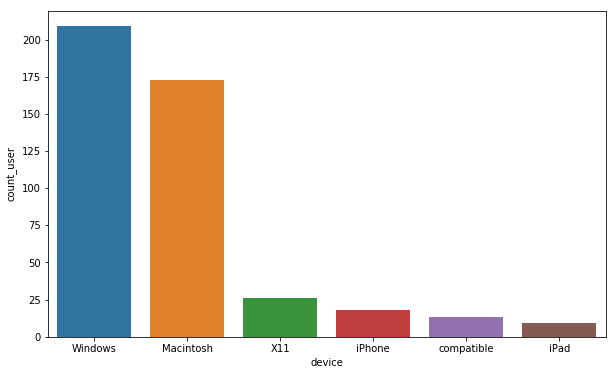

In [322]:
fig, ax = plt.subplots(figsize=(10,6))

g = sns.barplot(ax=ax, x="device", y="count_user", data=df_device)
plt.show()

We can check whether the interface platform contributes in churned users with this information.

### ts (timestamp) and registration

Let's view registration and ts for a user 293

In [177]:
df.filter(col("UserId") == 293).select(["registration", "ts", "page"]).sort(col("ts")).show()

+-------------+-------------+---------------+
| registration|           ts|           page|
+-------------+-------------+---------------+
|1532063507000|1538352011000|       NextSong|
|1532063507000|1538352608000|       NextSong|
|1532063507000|1538352788000|       NextSong|
|1532063507000|1538352789000|      Thumbs Up|
|1532063507000|1538353056000|       NextSong|
|1532063507000|1538353288000|       NextSong|
|1532063507000|1538353527000|       NextSong|
|1532063507000|1538353716000|       NextSong|
|1532063507000|1538354011000|       NextSong|
|1532063507000|1538354251000|       NextSong|
|1532063507000|1538354431000|       NextSong|
|1532063507000|1538354770000|       NextSong|
|1532063507000|1538355003000|       NextSong|
|1532063507000|1538355004000|         Logout|
|1532063507000|1538355201000|           Home|
|1532063507000|1538355202000|     Add Friend|
|1532063507000|1538355235000|       NextSong|
|1532063507000|1538355444000|       NextSong|
|1532063507000|1538355470000|Add t

**"Unix timestamp no pretty. Me want normal datetime."** - Probably a person alive before 1st Jan 1970

In [178]:
ts_dt_udf = udf(lambda x: x//1000, LongType())

In [179]:
ts_dt_udf = udf(lambda x: x//1000, LongType())
df = df.withColumn("registration_dt", ts_dt_udf(df.registration).cast("timestamp"))
df = df.withColumn("timestamp_dt", ts_dt_udf(df.ts).cast("timestamp"))

In [180]:
df.filter(col("UserId") == 293).select(["registration_dt", "timestamp_dt", "page"]).sort(col("timestamp_dt")).show()

+-------------------+-------------------+---------------+
|    registration_dt|       timestamp_dt|           page|
+-------------------+-------------------+---------------+
|2018-07-20 10:41:47|2018-10-01 05:30:11|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:40:08|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:43:08|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:43:09|      Thumbs Up|
|2018-07-20 10:41:47|2018-10-01 05:47:36|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:51:28|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:55:27|       NextSong|
|2018-07-20 10:41:47|2018-10-01 05:58:36|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:03:31|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:07:31|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:10:31|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:16:10|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:20:03|       NextSong|
|2018-07-20 10:41:47|2018-10-01 06:20:04|         Logout|
|2018-07-20 10

In [181]:
# Timeframe of the dataset we have at hand
df.agg(min("timestamp_dt"), max("timestamp_dt")).show()

+-------------------+-------------------+
|  min(timestamp_dt)|  max(timestamp_dt)|
+-------------------+-------------------+
|2018-10-01 05:30:11|2018-12-01 05:31:06|
+-------------------+-------------------+



In [182]:
# Timeframe of registrations
df.agg(min("registration_dt"), max("registration_dt")).show()

+--------------------+--------------------+
|min(registration_dt)|max(registration_dt)|
+--------------------+--------------------+
| 2017-11-05 09:26:33| 2018-11-24 21:07:54|
+--------------------+--------------------+



## Correlation scatter plot
Let's see if the variables in the dataset are derivatives of each other and whether we can eliminate some.

In [183]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('device', 'string'),
 ('registration_dt', 'timestamp'),
 ('timestamp_dt', 'timestamp')]

In [184]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'bigint']

sampled_data = df.select(numeric_features).sample(False, 0.10).toPandas()
sampled_data
# axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));
corr = sampled_data.corr()
corr.style.background_gradient()

,itemInSession,registration,sessionId,status,ts
itemInSession,1,0.00353557,0.13825,-0.00664991,0.0656965
registration,0.00353557,1,-0.022061,0.00683762,0.010414
sessionId,0.13825,-0.022061,1,-0.0235312,0.691641
status,-0.00664991,0.00683762,-0.0235312,1,-0.00362669
ts,0.0656965,0.010414,0.691641,-0.00362669,1


'ts' and 'sessionId' seem to have a correlation between them. Let's check that out.

In [185]:
session_ts_df = df.select(["timestamp_dt", "sessionId"]).sort(col("timestamp_dt")).toPandas()

/home/niraj/.virtualenvs/text/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KeyboardInterrupt: 

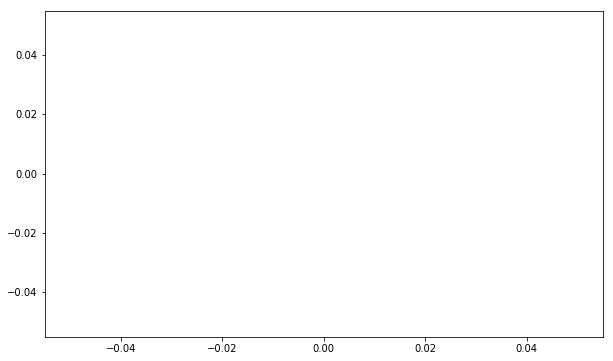

In [186]:
fig, ax = plt.subplots(figsize=(10,6))

g = sns.lineplot(ax=ax, x="timestamp_dt", y="sessionId", data=session_ts_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

Can't really speculate anything from this graph except there seems to be a pseudo linear relationship.

# Exploratory Data Analysis

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [188]:
cancelled_users = df.filter(col("page") == "Cancellation Confirmation").select("userId").toPandas().userId.tolist()

In [190]:
df = df.withColumn("churned", df.userId.isin(cancelled_users))

In [191]:
df.groupBy("churned").agg(countDistinct("userId")).show()

+-------+----------------------+
|churned|count(DISTINCT userId)|
+-------+----------------------+
|   true|                    99|
|  false|                   349|
+-------+----------------------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Platform used

In [197]:
df_device = df.groupBy("device", "churned").agg(countDistinct("UserId").alias("count_user")).sort(col("count_user").desc()).toPandas()

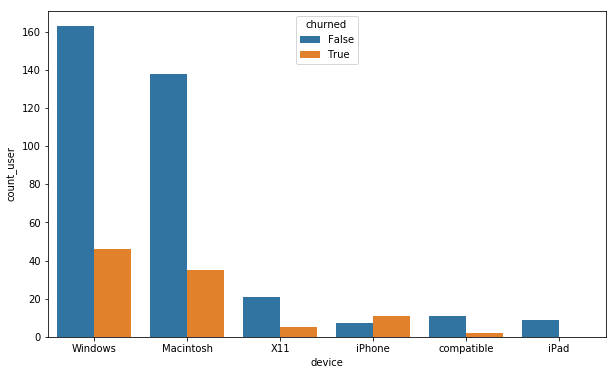

In [198]:
fig, ax = plt.subplots(figsize=(10,6))

g = sns.barplot(ax=ax, x="device", y="count_user", hue="churned", data=df_device)
plt.show()

We can observe that churned users are more than non churned users for iPhone. 

In [291]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- device: string (nullable = true)



In [263]:
df = df.drop(*["device_index", "device_classVec"])

In [293]:
df = df.select(["userId", "device"]).distinct()

In [296]:
df = StringIndexer(inputCol = "device", outputCol="device_index").fit(df).transform(df)
df = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=["device_classVec"]).fit(df).transform(df)

In [234]:
df = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=["device_classVec"]).fit(df).transform(df)

In [297]:
df.toPandas().head()

,userId,device,device_index,device_classVec
0,200008,Windows,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)"
1,114,Windows,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)"
2,260,Windows,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)"
3,200025,Windows,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)"
4,166,Macintosh,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)"


#### Time since registration until last action timestamp

In [237]:
user_ages = df.select(["userId", "churned", datediff("timestamp_dt", "registration_dt")]).groupBy(["userId", "churned"]).max().select("churned", col("max(datediff(timestamp_dt, registration_dt))").alias("age"))

In [238]:
user_ages.groupBy("churned").mean().toPandas()

,churned,avg(age)
0,True,68.010101
1,False,87.074499


This shows that churned users used the sparkify app for less periods of times on an average than non-churned users.

#### Number of events/actions transpired in given users' timelines

In [239]:
user_number_events = df.groupBy(["userId", "churned"]).count().select("churned", col("count").alias("number_events"))

In [240]:
user_number_events.groupBy("churned").mean().toPandas()

,churned,avg(number_events)
0,True,1046.929293
1,False,1215.928367


On an average, churned users have less number of interactions than non-churned users. 

#### Number of thumbs down/thumbs up given by churned vs non-churned users

In [241]:
users_thumbs_down = df.filter(col("page") == "Thumbs Down").groupBy(["churned", "userId"]).count()

In [242]:
users_thumbs_down.groupBy("churned").mean().toPandas()

,churned,avg(count)
0,True,12.988764
1,False,12.516667


On an average, people who thumbs down more often indicate signs of churning.

In [244]:
users_thumbs_down = df.filter(col("page") == "Thumbs Up").groupBy(["churned", "userId"]).count()

In [245]:
users_thumbs_down.groupBy("churned").mean().toPandas()

,churned,avg(count)
0,True,43.877551
1,False,57.260997


#### Number of sessions per user

Let's take a look at one user's session shenanigans.

In [43]:
df.filter(col("userId")==209).groupBy("sessionId").count().sort(col("count").desc()).show(100)

+---------+-----+
|sessionId|count|
+---------+-----+
|     4101|  433|
|     2687|  296|
|      443|  204|
|     2063|  204|
|     4211|  197|
|     4480|  138|
|     1361|   80|
|     3437|   73|
|     3360|   58|
|     4774|   39|
|     2943|   37|
|     4252|   13|
+---------+-----+



In [246]:
user_number_sessions = df.groupBy(["userId", "churned"]).agg(countDistinct("sessionId")).select("churned", col("count(DISTINCT sessionId)").alias("number of sessions"))

In [247]:
user_number_sessions.show()

+-------+------------------+
|churned|number of sessions|
+-------+------------------+
|  false|                13|
|  false|                 3|
|  false|                12|
|  false|                 5|
|   true|                 2|
|  false|                 2|
|   true|                 3|
|  false|                13|
|  false|                 6|
|   true|                 2|
|   true|                20|
|  false|                37|
|   true|                26|
|   true|                 6|
|  false|                11|
|  false|                 2|
|   true|                22|
|  false|                16|
|  false|                18|
|  false|                 3|
+-------+------------------+
only showing top 20 rows



In [248]:
user_number_sessions.groupBy("churned").mean().toPandas()

,churned,avg(number of sessions)
0,True,12.090909
1,False,13.991404


#### Page counts distribution among users (Features done, visualization and exploration necessary)

In [249]:
pages = df.select('page').distinct().sort('page')
pages_list = [r.page for r in pages.collect()]
page_counts = df.groupby('userId').pivot('page', pages_list).count()

In [250]:
df_page = df.groupBy(["churned", "page"]).count().toPandas()

In [251]:
df_page["log_count"] = np.log(df_page["count"])

In [252]:
df_page.head()

,churned,page,count,log_count
0,False,Save Settings,481,6.175867
1,True,Logout,1184,7.076654
2,False,Submit Downgrade,88,4.477337
3,False,NextSong,348518,12.761445
4,True,Save Settings,104,4.644391


In [253]:
df_page = df_page[~df_page.page.isin(['Cancellation Confirmation', 'Cancel'])]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

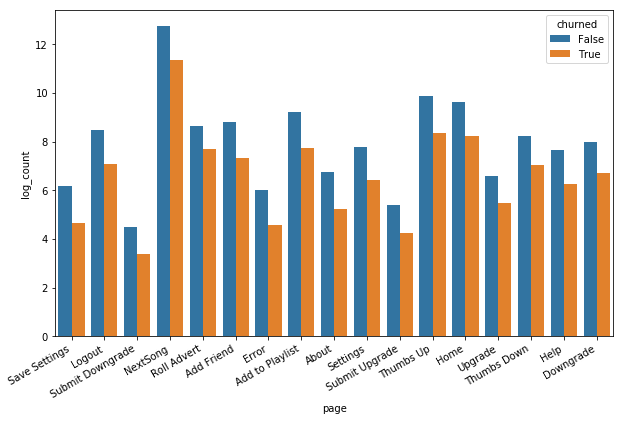

In [254]:
plt.figure(figsize=(10, 6))
sns.barplot(x='page',
            y='log_count',
            hue='churned',
            data=df_page)
plt.xticks(rotation=30, ha="right")

Visually the difference between churned and non churned users is less for 'Roll Advert' page which is understandable. It seems that free users are majority of churned users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**Note**: We will append all the relevant columns corresponding to each user

In [301]:
feature_df = df.select("userId").distinct()
col_names = []

In [302]:
feature_df = feature_df.join(df.select("userId", "device_classVec"), on="userId")

In [303]:
feature_df.show()

+------+---------------+
|userId|device_classVec|
+------+---------------+
|100010|  (5,[3],[1.0])|
|200002|  (5,[3],[1.0])|
|   296|  (5,[1],[1.0])|
|   125|  (5,[1],[1.0])|
|   124|  (5,[1],[1.0])|
|    51|  (5,[0],[1.0])|
|     7|  (5,[0],[1.0])|
|200037|  (5,[3],[1.0])|
|   169|  (5,[1],[1.0])|
|   205|  (5,[1],[1.0])|
|   272|  (5,[0],[1.0])|
|    15|  (5,[0],[1.0])|
|   232|  (5,[1],[1.0])|
|   234|  (5,[0],[1.0])|
|   282|  (5,[0],[1.0])|
|    54|  (5,[0],[1.0])|
|   155|  (5,[1],[1.0])|
|200043|  (5,[1],[1.0])|
|100014|  (5,[0],[1.0])|
|   132|  (5,[1],[1.0])|
+------+---------------+
only showing top 20 rows



### Session counts for each user

In [96]:
session_counts = df.groupby('userId').agg(countDistinct('sessionId').alias('session_count'))
session_counts.show()

+------+-------------+
|userId|session_count|
+------+-------------+
|200002|            5|
|   296|            5|
|100010|            2|
|   125|            3|
|     7|           15|
|   124|           17|
|    51|            5|
|200037|            7|
|   205|            5|
|   169|            8|
|   272|            2|
|   282|           29|
|    15|           18|
|    54|            8|
|   234|           26|
|   232|           23|
|200043|           12|
|   155|            4|
|100014|            4|
|   154|            4|
+------+-------------+
only showing top 20 rows



In [97]:
feature_df = feature_df.join(session_counts, on="userId")
col_names.append("session_count")

In [98]:
feature_df.show()

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            2|
|200002|            5|
|   296|            5|
|   125|            3|
|   124|           17|
|    51|            5|
|     7|           15|
|200037|            7|
|   169|            8|
|   205|            5|
|   272|            2|
|    15|           18|
|   232|           23|
|   234|           26|
|   282|           29|
|    54|            8|
|   155|            4|
|200043|           12|
|100014|            4|
|   132|            2|
+------+-------------+
only showing top 20 rows



### Counts of each event action (page) per user

In [99]:
pages = df.select('page').distinct().sort('page')
pages_list = [r.page for r in pages.collect()]
page_counts = df.groupby('userId').pivot('page', pages_list).count()

In [100]:
# Drop the "Cancel" page column
page_counts = page_counts.drop("Cancel")

# Fill NaNs with 0 - This will inherently transform "Cancellation Confirmation" into "churn"
page_counts = page_counts.fillna(value=0)

# Rename Cancellation Confirmation column to churn
page_counts = page_counts.withColumnRenamed("Cancellation Confirmation", "Churn")

In [101]:
page_counts.toPandas().head()

,userId,About,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,1,2,6,1,3,0,1,23,11,310,11,0,2,0,1,5,15,2
1,100010,0,3,1,1,0,0,0,3,1,96,22,0,0,0,0,3,4,2
2,296,0,2,3,1,1,0,2,7,3,112,9,0,1,0,1,0,8,1
3,125,0,3,2,0,0,0,2,2,0,62,6,0,3,0,0,1,3,0
4,51,0,3,8,1,4,2,0,17,6,266,1,0,2,0,0,1,16,0


In [102]:
# Join these feature columns to our feature dataframe
feature_df = feature_df.join(page_counts, on="userId")
col_names.extend(list(page_counts.toPandas().columns))

In [137]:
col_names

[]

### Time since registration

In [16]:
user_ages = df.select(["userId", datediff("timestamp_dt", "registration_dt")]).groupBy("userId").max().select("userId", col("max(datediff(timestamp_dt, registration_dt))").alias("age"))

In [111]:
feature_df = feature_df.join(user_ages, on='userId')
col_names.append("age")

### Number of events

In [18]:
user_number_events = df.groupBy("userId").count().select("userId", col("count").alias("num_events"))
feature_df = feature_df.join(user_number_events, on="userId")
col_names.append("num_events")

## Combine everything into a function

In [326]:
def extract_features(df):
    """
    Create a vector Assembler of the features.
    """
    feature_df = df.select("userId").distinct()
    col_names = []
    
    ts_dt_udf = udf(lambda x: x//1000, LongType())
    df = df.withColumn("registration_dt", ts_dt_udf(df.registration).cast("timestamp"))
    df = df.withColumn("timestamp_dt", ts_dt_udf(df.ts).cast("timestamp"))
    
    # Session Counts
    session_counts = df.groupby('userId').agg(countDistinct('sessionId').alias('session_count'))
    
    feature_df = feature_df.join(session_counts, on="userId")
    col_names.append("session_count")

    
    # Page Counts
    pages = df.select('page').distinct().sort('page')
    pages_list = [r.page for r in pages.collect()]
    page_counts = df.groupby('userId').pivot('page', pages_list).count()
    
    # Drop the "Cancel" page column
    # Fill NaNs with 0 - This will inherently transform "Cancellation Confirmation" column into "label" 
    # with 1 as churned and 0 as non churned
    page_counts = page_counts.drop("Cancel")
    page_counts = page_counts.fillna(value=0)
    page_counts = page_counts.withColumnRenamed("Cancellation Confirmation", "label")
    
    # Join these feature columns to our feature dataframe
    feature_df = feature_df.join(page_counts, on="userId")
    
    # Normalize by session counts
    cut_columns = {'userId', 'session_count', 'label'}
    remaining_cols = sorted(list(set(feature_df.columns) - cut_columns))
    for column in remaining_cols:
        feature_df = feature_df.withColumn(column, col(column) / feature_df.session_count)
    col_names.extend(remaining_cols)
    
    
    #col_names.extend(list(page_counts.toPandas().columns))

    
    # Time since registration
    user_ages = df.select(["userId", datediff("timestamp_dt", "registration_dt")]).groupBy("userId").max().select("userId", col("max(datediff(timestamp_dt, registration_dt))").alias("age"))    
    feature_df = feature_df.join(user_ages, on="userId")
    col_names.append("age")
    
    # Total number of events 
    user_number_events = df.groupBy("userId").count().select("userId", col("count").alias("num_events"))
    feature_df = feature_df.join(user_number_events, on="userId")
    col_names.append("num_events")
    
    # Include device categorical variable
    device_udf = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())
    df = df.withColumn("device", device_udf(df.userAgent))

    df_device = df.select(["userId", "device"]).distinct()
    df_device = StringIndexer(inputCol = "device", outputCol="device_index").fit(df_device).transform(df_device)
    df_device = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=["device_classVec"]).fit(df_device).transform(df_device)
    feature_df = feature_df.join(df_device.select("userId", "device_classVec"), on="userId")
    col_names.append("device_classVec")
    # Remove user_id string from input columns
    # col_names = list(set(col_names)-{'userId', 'sessionCount', 'label'})
    print(col_names)
    # Assemble the vector
    assembler = VectorAssembler(inputCols=col_names, outputCol='features')
    
    return assembler.transform(feature_df), col_names

In [327]:
# Extract features
feature_df, col_names = extract_features(df)

['session_count', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'age', 'num_events', 'device_classVec']


In [328]:
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- session_count: long (nullable = false)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- label: long (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- num_events: long (nullable = false)
 |-- device_classVec: vector (nullable = true)
 |-- features: vector (nullable = true)



In [329]:
feature_df.head(1)

[Row(userId='100010', session_count=2, About=0.0, Add Friend=1.5, Add to Playlist=0.5, label=1, Downgrade=0.0, Error=0.0, Help=0.0, Home=1.5, Logout=0.5, NextSong=48.0, Roll Advert=11.0, Save Settings=0.0, Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=0.0, Thumbs Down=1.5, Thumbs Up=2.0, Upgrade=1.0, age=14, num_events=137, device_classVec=SparseVector(5, {3: 1.0}), features=SparseVector(25, {0: 2.0, 2: 1.5, 3: 0.5, 7: 1.5, 8: 0.5, 9: 48.0, 10: 11.0, 15: 1.5, 16: 2.0, 17: 1.0, 18: 14.0, 19: 137.0, 23: 1.0}))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [330]:
feature_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  349|
|    1|   99|
+-----+-----+



In [331]:
train, test = feature_df.randomSplit([0.8, 0.2], 42)

In [332]:
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  275|
|    1|   87|
+-----+-----+



In [333]:
test.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   74|
|    1|   12|
+-----+-----+



## Logistic Regression

In [364]:
def get_metrics(res):
    """Given a results vector returns accuracy and f1-score"""
    total = res.count()
    
    tp = res.where((res.label==1) & (res.prediction==1)).count()
    tn = res.where((res.label==0) & (res.prediction==0)).count()
    
    fp = res.where((res.label==0) & (res.prediction==1)).count()
    fn = res.where((res.label==1) & (res.prediction==0)).count()
        
    accuracy = (1.0*tp + tn) / total
    precision = 1.0*tp / (tp + fp)
    recall = 1.0*tp / (tp + fn)
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

In [361]:
lr =  LogisticRegression(labelCol="label", featuresCol="features", maxIter=30, regParam=0.0, elasticNetParam=0)
model = lr.fit(train)

In [362]:
test_predictions = model.transform(test)

In [365]:
get_metrics(test_predictions)

Accuracy:  0.84
Precision:  0.43
Recall:  0.5
F1-Score:  0.46


In [382]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [ ]:
cvModel = crossval.fit(train)

In [ ]:
predictions = cvModel.transform(test)

In [ ]:
get_metrics(predictions)

In [ ]:
print("Elastic Net Parameter:{}".format(cvModel.bestModel._java_obj.getElasticNetParam()))
print("Fit Intercept Parameter:{}".format(cvModel.bestModel._java_obj.getFitIntercept()))
print("Regularization Parameter:{}".format(cvModel.bestModel._java_obj.getRegParam()))

## Decision Tree

In [339]:
decision_tree_model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = decision_tree_model.fit(train)
results_dt = dt_model.transform(test)
get_metrics(results_dt)

Accuracy:  0.86
Precision:  0.5
Recall:  0.33
F1-Score:  0.4


## Random Forest

In [340]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)
get_metrics(results_dt)

Accuracy:  0.86
Precision:  0.5
Recall:  0.33
F1-Score:  0.4


## Gradient Boosted Trees

In [341]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train)
results_gbt = gbt_model.transform(test)
get_metrics(results_gbt)

Accuracy:  0.85
Precision:  0.44
Recall:  0.33
F1-Score:  0.38


## Fine tuning

In [342]:
rf_paramGrid = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [3,7]) \
                .addGrid(rf.minInstancesPerNode, [3, 5]) \
                .addGrid(rf.numTrees, [10, 20, 30, 40]) \
                .build()

In [343]:
rf_crossval = CrossValidator(estimator = rf,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds=3)

In [344]:
rf_cross_model = rf_crossval.fit(train)

In [345]:
results_rf_cross = rf_cross_model.transform(test)

In [346]:
rf_cross_model.avgMetrics

[0.7078496917695946,
 0.6311182916158642,
 0.7030986688146883,
 0.6169236129794381,
 0.6981606744956262,
 0.6948514272543397,
 0.6847484890567417,
 0.6761847235148204,
 0.690249622591856,
 0.7071814025697523,
 0.6785053432504891,
 0.6973630462708132]

In [347]:
get_metrics(results_rf_cross)

Accuracy:  0.87
Precision:  0.6
Recall:  0.25
F1-Score:  0.35


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.